In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from os import getcwd, path

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

import matplotlib.pyplot as plt

from collections import defaultdict

import xgboost as xgb

from re import compile

plt.style.use('ggplot')

## Parameters

In [3]:
sent_tokenizer = False # S
use_pretrained_embeddings = True

use_nltk_cleaning = False
text_cleaning = True

use_tfidf_tokenizer = True
use_keras_tokenizer = False

make_all_other_classes_1 = True
remove_class_0 = False

run_XGBoost = True

## Functions

In [2]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix


def cal_label_accuracy(conf_matrix, verbose = 0):
    
    label_acc = {}
    
    for index, x in enumerate(conf_matrix): 
        
        label_acc[index] = np.round( conf_matrix[index][index]/ sum(conf_matrix[index]) *100 , 2)
        
        if verbose > 0:
        
            print("Accuracy for label", index, ": ", label_acc[index] , " %" )
    
    return label_acc

    
def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


## Data Ingest

## Use 5 Category Data

In [10]:
data_dir = '../data/ML_data_3.0.xlsx'
corpus = pd.read_excel(data_dir ,engine='openpyxl')

corpus = corpus[~corpus['label'].isna()][['text','label']]

 # Filter all NAs values
corpus.dropna(inplace= True)

 # Make Sure labels are integers
corpus['label'] = corpus['label'].astype(int)



In [11]:
corpus['label'].unique()

array([0, 4, 1, 3, 2])

## Use 2 Category Data

In [120]:
# current_path = getcwd()

# filepath_dict = {'yelp':   'data/yelp_labelled.txt',
#                  'amazon': 'data/amazon_cells_labelled.txt',
#                  'imdb':   'data/imdb_labelled.txt'}

# df_list = []

# for source, filepath in filepath_dict.items():
    
#     df = pd.read_csv(path.join(current_path, filepath), names=['sentence', 'label'], sep='\t')
#     df['source'] = source  # Add another column filled with the source name
#     df_list.append(df)

# df = pd.concat(df_list)
# df.rename(columns = {'sentence':'text'}, inplace = True)
# corpus = df

In [121]:
corpus.head()

,text,label
0,The stable way of business life many corporate...,0
1,"As dozens of companies have already learned, s...",0
2,What capabilities will a profitable internatio...,0
3,Almost every kind of manufacturer will have to...,0
4,Some companies have already responded to the g...,0


In [122]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2006 entries, 0 to 2006
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2006 non-null   object
 1   label   2006 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 39.2+ KB


## 0. Text Cleaning

In [13]:
if text_cleaning:

    corpus = corpus.reset_index(drop=True)

    REPLACE_BY_SPACE_RE = compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
  
    corpus['text'] = corpus['text'].apply(clean_text)
    corpus['text'] = corpus['text'].str.replace('\d+', '')

In [16]:
# Create Filter on the data to avoid the imbalance classes problem


# if make_all_other_classes_1:

#     corpus['label_orignal'] = corpus.loc[:,'label']
#     corpus['label'] = np.where( corpus['label'] > 0 , 1, corpus['label'])

# elif remove_class_0:

#     corpus['label_orignal'] = corpus.loc[:,'label']
#     corpus = corpus[~corpus['label'].isin([0])]
#     corpus['label'] = corpus['label'].map({1:0,2:1,3:2,4:3})

In [17]:
corpus.head()

,text,label
0,stable way business life many corporate purcha...,0
1,dozens companies already learned supply demand...,0
2,capabilities profitable international business...,0
3,almost every kind manufacturer answer questions,0
4,companies already responded growing pressures,0


In [18]:
corpus['label'].unique()

array([0, 4, 1, 3, 2])

## 1. NLTK - Data preprocessing

- I. Remove Blank rows in Data, if any
- II. Change all the text to lower case
- III. Word Tokenization
- IV. Remove Stop words
- V. Remove Non-alpha text
- VI. Word Lemmatization

In [19]:
# if use_nltk_cleaning:

#     # Step III : Tokenization : In this each entry in the corpus will be broken into set of words
#     if sent_tokenizer: 
#         corpus['text'] = [sent_tokenize(x) for x in corpus['text']] 
#     else:
#         #Corpus['text'] = Corpus['text'].apply(lambda x: str(word_tokenize(x)) )
#         corpus['text'] = [word_tokenize(x) for x in corpus['text']]

#     # Step IV, V, VI : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
#     # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
#     # Word Classification for Lemmatizer https://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html
#     # https://www.geeksforgeeks.org/defaultdict-in-python/
#     tag_map = defaultdict(lambda: wn.NOUN)
#     tag_map['J'] = wn.ADJ
#     tag_map['V'] = wn.VERB
#     tag_map['R'] = wn.ADV

#     # Execute Word Tagging
#     for index, entry in enumerate(corpus['text']):

#         # Declaring Empty List to store the words that follow the rules for this step
#         lemma_words = []

#         # Initializing WordNetLemmatizer()
#         word_Lemmatized = WordNetLemmatizer()

#         # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
#         # Posttagging reference : https://www.nltk.org/book/ch05.html 

#         for word, tag in pos_tag(entry):

#             # Below condition is to check for Stop words and consider only alphabets
#             # List of stop words https://gist.github.com/sebleier/554280, https://www.nltk.org/book/ch02.html

#             # NLTK check for an alphabetic word https://tedboy.github.io/nlps/generated/generated/nltk.text_type.isalpha.html
#             if word not in stopwords.words('english') and word.isalpha():

#                 # Reference https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
#                 # Use first letter of NLTK Postagging as "pos" parameter mapping it through the dict tag_map
#                 lemma_word = word_Lemmatized.lemmatize(word = word,
#                                                        pos = tag_map[tag[0]]  )
#                 # Append word back to the empty list
#                 lemma_words.append(lemma_word)

#         # The final processed set of words for each iteration will be stored in 'text_final'
#         corpus.loc[index,'text_clean'] = ' '.join(lemma_words)
    
#     corpus.loc[:,'text'] = corpus['text_clean']

## 2. Prepare Trainig and Test data

In [20]:
# Get training X data
sentences = corpus['text'].values

# Use Label encoder for the expected output
Encoder = LabelEncoder()
encoded_Y = Encoder.fit_transform(corpus['label'].values)
Y = pd.get_dummies(encoded_Y).values

sentences_train, sentences_test, Y_train, Y_test = train_test_split( sentences, Y, test_size=0.25)

run_XGBoost = False
if run_XGBoost:

    sentences_train, sentences_test, Y_train_encoded, Y_test_encoded = train_test_split( sentences, encoded_Y, test_size=0.25)

In [21]:
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2130, 5)


## 3. Word Tokenizer 

In [23]:
# Hyperparameters
sent_tokenizer = False
use_nltk_cleaning = False
use_tfidf_tokenizer = True # TODO: Adjust for input to CNN
use_keras_tokenizer = True
use_pretrained_embeddings = True
use_tfidf_as_embedding_weights = True

# Initialize Model
epochs = 30
batch_size = 16
output_label = len(np.unique(encoded_Y))

# Append "0" add the sentences ending to have equal sentences length
seq_input_len = 50
num_word = 5000

In [28]:
if use_keras_tokenizer:
    
    # Start Tokenizer Object
    tokenizer = Tokenizer(num_words=num_word)

    # Train vocabulary
    tokenizer.fit_on_texts(sentences_train)

    X_train = tokenizer.texts_to_sequences(sentences_train) 
        
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # XGBoost ------------
    X = tokenizer.texts_to_sequences(sentences)
    #---------------------

    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
   
    vocab = tokenizer.word_index

    X_train_keras = pad_sequences(X_train, padding='post', maxlen=seq_input_len)
    X_test_keras = pad_sequences(X_test, padding='post', maxlen=seq_input_len)

    # XGBoost ------------
    #X_keras = pad_sequences(X, padding='post', maxlen=seq_input_len)
    #---------------------

use_tfidf_tokenizer = True
if use_tfidf_tokenizer:
    
    # Create new Class TfidfVectorizer with max 5000 features
    Tfidf_vect = TfidfVectorizer(max_features=5000)

    # Learn vocabulary and idf from training set
    Tfidf_vect.fit(sentences_train)

    # Transfor both the train and the test to document-term matrix
    X_train_Tfidf = Tfidf_vect.transform(sentences_train).toarray()
    X_test_Tfidf = Tfidf_vect.transform(sentences_test).toarray()

    #XGBoost -------
    #X_Tfidf = Tfidf_vect.transform(sentences)
    #----------
    
    vocab = Tfidf_vect.vocabulary_
    
    vocab_size = len(vocab) + 1

    

## 4. Use pre-trained Embedding Space ( GloVe )

In [26]:
if use_pretrained_embeddings: 
    
    embedding_dim = 300
    
    embedding_matrix = create_embedding_matrix(
     filepath = 'D:/Embeddings/GloVe/glove.6B.300d.txt',
     word_index = vocab, 
     embedding_dim = embedding_dim)

# 4. CNN With Keras

In [205]:
del model

In [206]:
model = Sequential()

if use_pretrained_embeddings:  

    # Use Glove Embedding Matrix
    
    model.add(layers.Embedding(vocab_size, embedding_dim,  # Word Vector Dimension
                                weights=[embedding_matrix], 
                                input_length=seq_input_len, 
                                trainable=False))
else: 
    
    # Keras Embedding Matrix Generation
    
    model.add(layers.Embedding(vocab_size, # Vocabulary Size
                                embedding_dim, # Word Vector Dimension
                                input_length = seq_input_len))

# Filters: No. of output filter in the convolution
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
model.add(layers.Conv1D(filters = 256, kernel_size = 2, activation='relu'))

# Filters: No. of output filter in the convolution
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
model.add(layers.Conv1D(filters = 64, kernel_size = 3, activation='relu'))

# Global max pooling operation for 1D temporal data.
# Downsamples the input representation by taking the maximum value over the time dimension
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 50, 300)           1051800   
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 49, 256)           153856    
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 47, 64)            49216     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 34        
Total params: 1,255,946
Trainable params: 204,146
Non-trainable params: 1,051,800
_____________________________________

Training Accuracy: 0.9987
Testing Accuracy:  0.8586


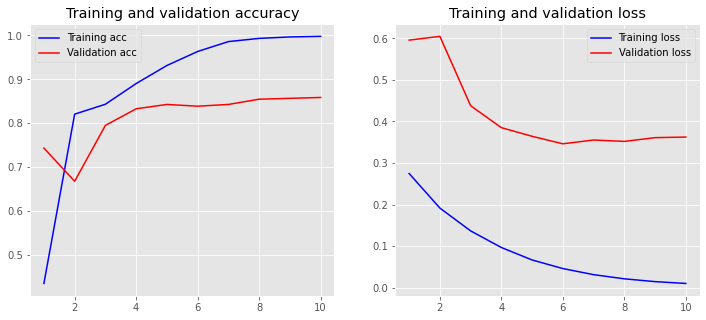

In [207]:
class_weight = {0: 0.25,
                1: 0.75}

history = model.fit(X_train_keras, Y_train,
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_keras, Y_test),
                    batch_size = batch_size, 
                    class_weight = class_weight)

loss, accuracy = model.evaluate(X_train_keras, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_keras, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [208]:
Y_pred = model.predict(X_test_keras)

for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  90.79  %
Accuracy for label 1 :  70.49  %


{0: 90.79, 1: 70.49}

## 4.1 CNN with TFIDF

In [29]:
# Principal Component Analysis - Para reducir dimensionalidad 
from sklearn.decomposition import PCA

# intialize pca and logistic regression model
TFIDF_matrix_dim = 50

pca = PCA(n_components = TFIDF_matrix_dim)

# fit and transform data
X_train_Tfidf = pca.fit_transform(X_train_Tfidf)
X_test_Tfidf = pca.transform(X_test_Tfidf)

In [30]:
model = Sequential()

model.add(layers.Embedding(vocab_size, embedding_dim, input_length=X_train_Tfidf.shape[1]))

# Filters: No. of output filter in the convolution
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
model.add(layers.Conv1D(filters = 256, kernel_size = 2, activation='relu'))

# Global max pooling operation for 1D temporal data.
# Downsamples the input representation by taking the maximum value over the time dimension
#model.add(layers.GlobalMaxPooling1D())
model.add(layers.Conv1D(filters = 32, kernel_size = 3, activation='relu'))

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           1098600   
_________________________________________________________________
conv1d (Conv1D)              (None, 49, 256)           153856    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 47, 32)            24608     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                330       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
Total params: 1,277,449
Trainable params: 1,277,449
Non-trainable params: 0
______________________________________________

In [32]:
history = model.fit(X_train_Tfidf, Y_train,
                    epochs = epochs,
                    verbose = True,
                    validation_data = (X_test_Tfidf, Y_test),
                    batch_size = batch_size)

loss, accuracy = model.evaluate(X_train_Tfidf, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_Tfidf, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Epoch 1/30
100/100 [==============================] - 2s 25ms/step - loss: 1.0335 - accuracy: 0.6994 - val_loss: 1.0038 - val_accuracy: 0.7148
Epoch 2/30
100/100 [==============================] - 2s 24ms/step - loss: 1.0310 - accuracy: 0.6994 - val_loss: 1.0041 - val_accuracy: 0.7148
Epoch 3/30
100/100 [==============================] - 2s 24ms/step - loss: 1.0351 - accuracy: 0.6994 - val_loss: 0.9916 - val_accuracy: 0.7148
Epoch 4/30
100/100 [==============================] - 2s 24ms/step - loss: 1.0306 - accuracy: 0.6994 - val_loss: 0.9923 - val_accuracy: 0.7148
Epoch 5/30
100/100 [==============================] - 2s 25ms/step - loss: 1.0311 - accuracy: 0.6994 - val_loss: 0.9927 - val_accuracy: 0.7148
Epoch 6/30
100/100 [==============================] - 2s 24ms/step - loss: 1.0285 - accuracy: 0.6994 - val_loss: 1.0115 - val_accuracy: 0.7148
Epoch 7/30
100/100 [==============================] - 2s 25ms/step - loss: 1.0331 - accuracy: 0.6994 - val_loss: 0.9948 - val_accuracy: 0.7148

KeyboardInterrupt: 

In [ ]:
Y_pred = model.predict(X_test_keras)

for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

In [ ]:
print ('MSE:',loss)
print ('MAE:',accuracy)
print ('r2:',r2_score(Y_test, Y_pred))
conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

## 7. Run Model - Recurrent Neural Networks - RNN

Reference: https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [212]:
del model

In [213]:
model = Sequential()

if use_pretrained_embeddings:  
  
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights = [embedding_matrix], 
                               input_length = seq_input_len, 
                               trainable = False))
else: 
    embedding_dim = 100 # Output Dimension - seq output length
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length = seq_input_len))
    
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation='softmax'))
model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [218]:
epochs

10

Epoch 1/10
6/6 [==============================] - 3s 488ms/step - loss: 0.2653 - accuracy: 0.7642 - val_loss: 0.5653 - val_accuracy: 0.7483
Epoch 2/10
6/6 [==============================] - 3s 476ms/step - loss: 0.2680 - accuracy: 0.7583 - val_loss: 0.5647 - val_accuracy: 0.7483
Epoch 3/10
6/6 [==============================] - 3s 462ms/step - loss: 0.2690 - accuracy: 0.7591 - val_loss: 0.5648 - val_accuracy: 0.7483
Epoch 4/10
6/6 [==============================] - 3s 470ms/step - loss: 0.2665 - accuracy: 0.7583 - val_loss: 0.5653 - val_accuracy: 0.7483
Epoch 5/10
6/6 [==============================] - 3s 458ms/step - loss: 0.2641 - accuracy: 0.7731 - val_loss: 0.5661 - val_accuracy: 0.7483
Training Accuracy: 0.7713
Testing Accuracy:  0.7908


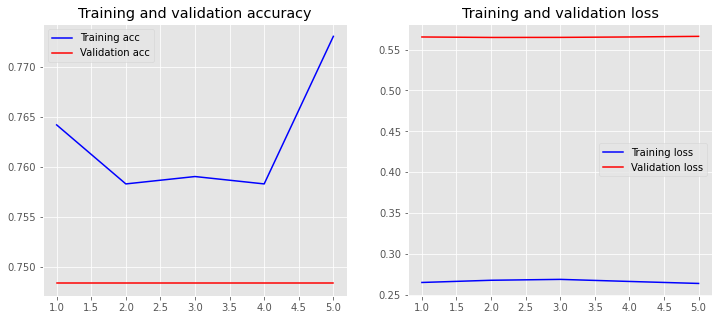

In [242]:
# train_x = np.asarray(X_train_keras)
# train_y = np.asarray(Y_train)
# validation_x = np.asarray(X_test_keras)
# validation_y = np.asarray(Y_test)
class_weight = {0: 0.25,
                1: 0.75}z


history = model.fit(X_train_keras, 
                    Y_train, 
                    epochs = 10, 
                    batch_size = batch_size,
                    validation_data = (X_test_keras, Y_test), 
                    validation_split=0.1,
                    verbose = True,
                    class_weight= class_weight,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


loss, accuracy = model.evaluate(X_train_keras, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_keras, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [243]:
Y_pred = model.predict(X_test_keras)

In [244]:
for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

In [245]:
conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  93.16  %
Accuracy for label 1 :  35.25  %


{0: 93.16, 1: 35.25}

## 8. GRU NN

In [246]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()


if use_pretrained_embeddings:  
  
    gru_model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights = [embedding_matrix], 
                               input_length = seq_input_len, 
                               trainable = False))
else: 
    embedding_dim = 100 # Output Dimension - seq output length
    gru_model.add(layers.Embedding(vocab_size, embedding_dim, input_length = seq_input_len))
    
gru_model.add(layers.GRU(32, return_sequences=False))
gru_model.add(layers.Dropout(0.5))
#gru_model.add(layers.Dense(10, activation='softmax'))
gru_model.add(layers.Dense(output_label, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 50, 300)           1051800   
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                32064     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 66        
Total params: 1,083,930
Trainable params: 32,130
Non-trainable params: 1,051,800
_________________________________________________________________
None


In [247]:
train_x = np.asarray(X_train_keras)
train_y = np.asarray(Y_train)
validation_x = np.asarray(X_test_keras)
validation_y = np.asarray(Y_test)

In [248]:
class_weight = {0: 0.25,
                1: 0.75}

history = gru_model.fit(train_x, 
                    train_y, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    validation_data = (validation_x, validation_y), 
                    class_weight = class_weight)

Epoch 1/10
6/6 [==============================] - 4s 226ms/step - loss: 0.2716 - accuracy: 0.4068 - val_loss: 0.7003 - val_accuracy: 0.2430
Epoch 2/10
6/6 [==============================] - 1s 111ms/step - loss: 0.2688 - accuracy: 0.2766 - val_loss: 0.7056 - val_accuracy: 0.2430
Epoch 3/10
6/6 [==============================] - 1s 108ms/step - loss: 0.2707 - accuracy: 0.2832 - val_loss: 0.7115 - val_accuracy: 0.2430
Epoch 4/10
6/6 [==============================] - 1s 105ms/step - loss: 0.2691 - accuracy: 0.2786 - val_loss: 0.7177 - val_accuracy: 0.2430
Epoch 5/10
6/6 [==============================] - 1s 112ms/step - loss: 0.2679 - accuracy: 0.2755 - val_loss: 0.7229 - val_accuracy: 0.2430
Epoch 6/10
6/6 [==============================] - 1s 113ms/step - loss: 0.2676 - accuracy: 0.2740 - val_loss: 0.7270 - val_accuracy: 0.2430
Epoch 7/10
6/6 [==============================] - 1s 113ms/step - loss: 0.2738 - accuracy: 0.2956 - val_loss: 0.7313 - val_accuracy: 0.2430
Epoch 8/10
6/6 [====

In [249]:

train_gru_results = gru_model.evaluate(train_x, train_y, verbose=0, batch_size=256)
test_gru_results = gru_model.evaluate(validation_x, validation_y, verbose=0, batch_size=256)
print(f'Train accuracy: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy: {test_gru_results[1]*100:0.2f}')

Train accuracy: 27.66
Test accuracy: 24.30


In [250]:
Y_pred = gru_model.predict(X_test_keras)

for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  0.0  %
Accuracy for label 1 :  100.0  %


{0: 0.0, 1: 100.0}

## 8. XGBoost


In [21]:
pl_xgb_tf_idf = Pipeline(steps=[('xgboost', xgb.XGBClassifier(objective='multi:softmax',num_class=2))])
#scores = cross_val_score(pl_xgb_tf_idf, X_Tfidf, encoded_Y, cv=5)
#print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())


In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
param_grid = dict(xgboost__n_estimators=[100,200,300])
grid_search = GridSearchCV(pl_xgb_tf_idf, param_grid=param_grid,cv=5)

In [25]:
grid_result = grid_search.fit(X_train_Tfidf, Y_train_encoded)

[17:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [69]:
#grid_search.predict(X_Tfidf[0:1])

array([1], dtype=int64)

In [26]:
test_accuracy = grid_search.score(X_test_Tfidf, Y_test_encoded)

In [28]:
Y_pred = grid_search.predict(X_test_Tfidf)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(Y_pred, Y_test_encoded) / len(Y_pred)

# Calculate Label Accuracy
label_acc = cal_label_accuracy(conf_matrix, verbose  = 1)

Accuracy for label 0 :  76.92  %
Accuracy for label 1 :  43.59  %
Accuracy for label 2 :  61.54  %
Accuracy for label 3 :  83.87  %


In [29]:
print('Accuracy for Tf-Idf & XGBoost Classifier : ',test_accuracy)

Accuracy for Tf-Idf & XGBoost Classifier :  0.6444444444444445
